Aya Eid

Tempus Test Case

# Include imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
%matplotlib inline

# Reading in and structuring data

In [2]:
targets = pd.read_csv('targets.csv')
data = pd.read_csv('biomarkers.csv')

In [3]:
# taking a look 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Columns: 15158 entries, biomarker_id to BM15156
dtypes: float64(46), int64(15111), object(1)
memory usage: 226.7+ MB


In [4]:
# append targets to features to establish data matrix
data['target'] = np.full(len(data),np.nan)
for b_ind in range(0, len(targets)):   
    bid = targets.loc[b_ind]['biomarker_id']
    target = targets.loc[b_ind]['target_label']
    data.target.loc[data['biomarker_id']==bid] = target

C:\Users\ayaei\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
# remove any observations without target data
data.dropna(subset=['target'],inplace=True)  

# Looking a little closer at the data, I found a few features that have numerous missing values. 
# For now, let's just remove them entirely
data.dropna(axis=1,inplace=True)


In [29]:
data.head()

,biomarker_id,BM00000,BM00001,BM00002,BM00003,BM00004,BM00005,BM00006,BM00007,BM00008,...,BM15147,BM15148,BM15149,BM15150,BM15151,BM15152,BM15153,BM15155,BM15156,target
0,100505de2,1,1,1,0,0,0,1,0,0,...,1,0,1,1,0,0,1,1,1,0.0
1,10075c5c2,1,1,1,0,0,0,1,0,1,...,1,0,0,0,0,0,1,1,1,1.0
2,10105cb22,1,1,1,0,0,0,1,0,1,...,1,0,0,0,0,0,1,1,1,1.0
3,101219d6e,1,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,1,1,1,0.0
4,10135ad45,1,0,1,0,1,0,1,0,1,...,1,0,1,0,0,0,1,1,1,0.0


In [26]:
# first separate the data into test and train sets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
X = data.drop(['target','biomarker_id'],axis=1)
y = data['target']

#X = X.to_numpy()
#y = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# here we get a feeling for how well a RF classifier will do
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=50, random_state=50)
model.fit(X_train, y_train)
predictions = np.round(model.predict(X_test))

print(classification_report(predictions, y_test))
print(confusion_matrix(predictions, y_test))

# We see here that this model is as good as naively classifying all outputs as negatives. 
# While the TN rate is good, the TP is terrible
# This is an ideal data set for a boosted approach 

              precision    recall  f1-score   support

         0.0       1.00      0.78      0.88       521
         1.0       0.00      0.00      0.00         0

    accuracy                           0.78       521
   macro avg       0.50      0.39      0.44       521
weighted avg       1.00      0.78      0.88       521

[[406 115]
 [  0   0]]


C:\Users\ayaei\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [11]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=100,max_depth=4)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(classification_report(predictions, y_test))
print(confusion_matrix(predictions, y_test))

              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93       456
         1.0       0.50      0.89      0.64        65

    accuracy                           0.88       521
   macro avg       0.74      0.88      0.79       521
weighted avg       0.92      0.88      0.89       521

[[399  57]
 [  7  58]]



Model Report
Accuracy : 0.8829
AUC Score (Test): 0.847
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93       455
         1.0       0.52      0.91      0.66        66

    accuracy                           0.88       521
   macro avg       0.75      0.89      0.80       521
weighted avg       0.93      0.88      0.90       521

[[400  55]
 [  6  60]]

Model Paramters
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=101, subsample=1.0, tol=0.0001,
          

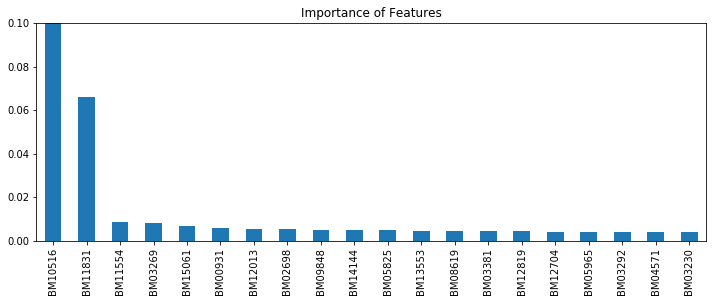

In [130]:
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV

X = data.drop(['target','biomarker_id'],axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# First order model (no parameter tuning...yet)
model = GradientBoostingClassifier(random_state=101)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
predprob = model.predict_proba(X_test)[:,1]
#cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

# Print model report
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, predictions))
print("AUC Score (Test): %4.3f" % metrics.roc_auc_score(y_test, predprob))
#print("CV Score : Mean = %.7g | Std = %.7g | Min = %.7g | Max = %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))    
print(classification_report(predictions, y_test))
print(confusion_matrix(predictions, y_test))
print('\nModel Paramters')
print(model)

feat_imp = pd.Series(model.feature_importances_, list(X_train)).sort_values(ascending=False)
feat_imp.iloc[0:20].plot(kind='bar', title='Importance of Features')
plt.ylim([0,.1])
plt.show()

In [113]:
# Tuning n_estimators for a learning rate of 0.1
# Let's keep n_estimators = 100, since my little laptop can't handle much more 
n_estimators_B = 100
# param_test1 = {'n_estimators':range(100,501,25)}
# gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1, 
#                                                                min_samples_split = 50, 
#                                                                max_depth = 7, 
#                                                                max_features = 'sqrt', 
#                                                                subsample = 0.8, 
#                                                                random_state = 10), 
#                         param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
# gsearch1.fit(X_train,y_train)
# n_estimators_B = gsearch1.best_params_['n_estimators']
# gsearch1.best_params_, gsearch1.best_score_

In [114]:
# Tuning max_depth and min_samples_split
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(10,101,10)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1, 
                                                               n_estimators = n_estimators_B, 
                                                               max_features = 'sqrt', 
                                                               subsample = 0.8, 
                                                               random_state = 10), 
                        param_grid = param_test2, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch2.fit(X_train, y_train)
max_depth_B = gsearch2.best_params_['max_depth']
min_samples_split_B = gsearch2.best_params_['min_samples_split']

gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 11, 'min_samples_split': 80}, 0.7439344692969321)

In [110]:
# Tuning max_features 
# param_test4 = {'max_features':range(8,50,2)}
# gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1, 
#                                                                n_estimators = n_estimators_B,
#                                                                max_depth = max_depth_B, 
#                                                                min_samples_split = min_samples_split_B, 
#                                                                subsample = 0.8, 
#                                                                random_state = 10),
#                         param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch4.fit(X_train,y_train)
# max_features_B = gsearch4.best_params_['max_features']
# gsearch4.best_params_, gsearch4.best_score_

({'max_features': 18}, 0.6443371531554252)

In [115]:
# Second order model
model = GradientBoostingClassifier(random_state = 101, 
                                   learning_rate = 0.1, 
                                   n_estimators = n_estimators_B, 
                                   max_depth = max_depth_B, 
                                   min_samples_split = min_samples_split_B, #                                   max_features = max_features_B, 
                                   subsample = 0.8)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
predprob = model.predict_proba(X_test)[:,1]
#cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

# Print model report
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, predictions))
print("AUC Score (Test): %4.3f" % metrics.roc_auc_score(y_test, predprob))
#print("CV Score : Mean = %.7g | Std = %.7g | Min = %.7g | Max = %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))    
print(classification_report(predictions, y_test))
print(confusion_matrix(predictions, y_test))

KeyboardInterrupt: 


Model Report
Accuracy : 0.8829
AUC Score (Test): 0.842
CV Score : Mean = 0.5448971 | Std = 0.02682569 | Min = 0.4986523 | Max = 0.5808342
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93       455
         1.0       0.52      0.91      0.66        66

    accuracy                           0.88       521
   macro avg       0.75      0.89      0.80       521
weighted avg       0.93      0.88      0.90       521

[[400  55]
 [  6  60]]


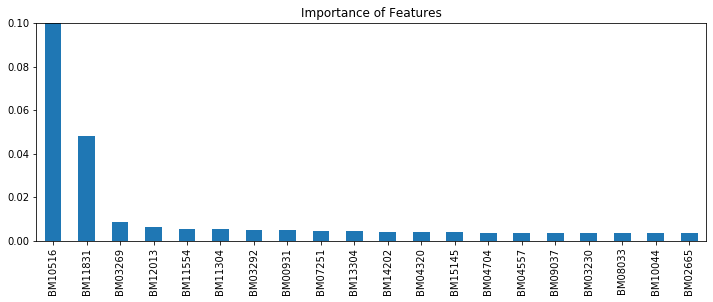

In [129]:

print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, predictions))
print("AUC Score (Test): %4.3f" % metrics.roc_auc_score(y_test, predprob))
print("CV Score : Mean = %.7g | Std = %.7g | Min = %.7g | Max = %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))    
print(classification_report(predictions, y_test))
print(confusion_matrix(predictions, y_test))
feat_imp = pd.Series(model.feature_importances_, list(X_train)).sort_values(ascending=False)
feat_imp.iloc[0:20].plot(kind='bar', title='Importance of Features')
plt.ylim([0,.1])
plt.show()


In [89]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
rf_exp = RandomForestRegressor(n_estimators= 500, random_state=100)
#rf_exp = RandomForestClassifier(n_estimators= 500, random_state=100, criterion='gini')
rf_exp.fit(X_train, y_train)
predictions = np.round(rf_exp.predict(X_test))

print(classification_report(predictions, y_test))
print(confusion_matrix(predictions, y_test))

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [90]:
#np.mean(np.round(predictions)!=test_labels)
predictions = np.round(predictions)
#predictions2 = False * np.ones(predictions.shape)
print(classification_report(predictions, y_test))
print(confusion_matrix(predictions, y_test))


              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93       764
         1.0       0.50      0.91      0.64       103

    accuracy                           0.88       867
   macro avg       0.74      0.89      0.79       867
weighted avg       0.93      0.88      0.89       867

[[669  95]
 [  9  94]]


In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))

C:\Users\ayaei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

         0.0       1.00      0.77      0.87       572
         1.0       0.00      0.00      0.00         1

    accuracy                           0.77       573
   macro avg       0.50      0.39      0.44       573
weighted avg       1.00      0.77      0.87       573

[[443 129]
 [  1   0]]


# Neural Network

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1)) 
model.compile(optimizer='rmsprop',loss='mse')  # optimzer depends on type of problem (binary, multiclass or regression)

model.fit(x=X_train,y=y_train, epochs=250,verbose=0)
predictions = np.round(model.predict(X_test))
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [ ]:
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))


In [14]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=0)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [16]:
predictions = dtree.predict(X_test)
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       478
           1       0.11      0.22      0.14        54

    accuracy                           0.73       532
   macro avg       0.50      0.51      0.49       532
weighted avg       0.82      0.73      0.77       532

[[377 101]
 [ 42  12]]


In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [18]:
clf.feature_importances_
predictions = clf.predict(X_test)

print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88       524
           1       0.03      0.38      0.05         8

    accuracy                           0.78       532
   macro avg       0.51      0.58      0.46       532
weighted avg       0.97      0.78      0.87       532

[[414 110]
 [  5   3]]


In [19]:
from sklearn.ensemble import RandomForestClassifier

[[375 101]
 [ 44  12]]


              precision    recall  f1-score   support

           0       0.89      0.79      0.84       476
           1       0.11      0.21      0.14        56

    accuracy                           0.73       532
   macro avg       0.50      0.50      0.49       532
weighted avg       0.81      0.73      0.76       532



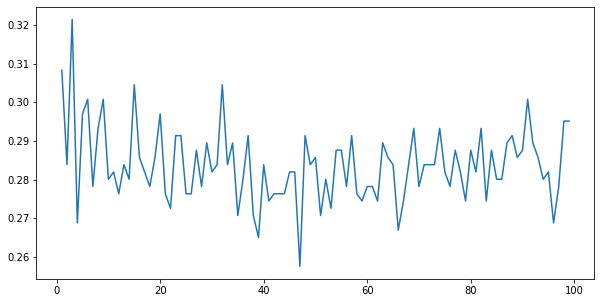

In [22]:
err = []
for i in range(1,100):
    rfc = RandomForestClassifier(n_estimators=i)
    rfc.fit(X_train, y_train)
    rfc_predictions = rfc.predict(X_test)
    err.append(np.mean(rfc_predictions!=y_test))
    #err.append(f1_score(y_test, rfc_predictions, average='weighted'))

plt.figure(figsize=(10,5))
plt.plot(range(1,100),err)  

rfc = RandomForestClassifier(n_estimators=11)
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)
#err.append(np.mean(rfc_predictions!=y_test))    
    
print(confusion_matrix(rfc_predictions,y_test))
print('\n')
print(classification_report(rfc_predictions,y_test))

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(1,100),err)    

In [23]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[419   0]
 [113   0]]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       419
           1       0.00      0.00      0.00       113

    accuracy                           0.79       532
   macro avg       0.39      0.50      0.44       532
weighted avg       0.62      0.79      0.69       532



C:\Users\ayaei\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ayaei\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:

# C controls the cost of misclassification of training
# large C gives low bias and high variance (overfitting) because you penalize the cost of misclassification
# low C underfits (high bias, low variance)

# gamma: radial basis function, gamma is a free param in it, small gamma gives a gaussian with a higher vairnace
# large gamma -> high variance low bias
# default gamma = 1/n_features
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[.001, .01, 0.1], 'gamma':[10,1,.1]}
grid = GridSearchCV(SVC(), param_grid, verbose=3)
grid.fit(X_train, y_train)
grid.best_params_
grid.best_estimator_
grid_predictions = grid.predict(X_test)


In [ ]:
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))
grid.best_params_

In [24]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=500)
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

C:\Users\ayaei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


NameError: name 'grid_predictions' is not defined

In [ ]:
logmodel

In [ ]:
#data['dst'].loc[data['biomarker_id']==pid] = check(patient_profiles[inst_ind]["patient_profiles"][pat_ind]['status'].get('disease_sub_type')
                                                   
                                                   
#check(patient_profiles[inst_ind]["patient_profiles"][pat_ind]['status'].get('disease_sub_type'))
data['dst'].loc[data['biomarker_id']==pid]
data.loc[data['biomarker_id']==pid]
data.head(20)


def check(val):
    if val:
        return val
    else:
        return np.nan
    
    
print(check(patient_profiles[inst_ind]["patient_profiles"][0]['demographics'].get('race')))
print(check(patient_profiles[inst_ind]["patient_profiles"][1]['demographics'].get('race')))


print(check(patient_profiles[1]["patient_profiles"][2]['demographics'].get('race')))

print(check(patient_profiles[6]["patient_profiles"][0]['demographics'].get('race')))



#data['dst'].loc[data['biomarker_id']==pid] = patient_profiles[inst_ind]["patient_profiles"][pat_ind]['status']['disease_sub_type']
        
#data.head()    
#data.isin(['89c43bb4'])    
#data[data['biomarker_id']=='89c43bb4']['institution'] = patient_profiles[0]["institution"]
#data['institution'].loc[data['biomarker_id']=='89c43bb4'] = patient_profiles[0]["institution"]

#inst_ind = 1
#pat_ind = 2
#patient_profiles[inst_ind]["patient_profiles"][pat_ind]['patient_id']
#patient_profiles[inst_ind]["patient_profiles"][pat_ind]['demographics']['gender']


In [ ]:
data.head()

In [ ]:
#len(patient_profiles[0]["patient_profiles"])
#pid = patient_profiles[0]["patient_profiles"][0]['patient_id']
#pid
#data.loc['10e32947f']

patient_profiles[0]["institution"]

In [ ]:
print(json.dumps(patient_profiles, indent=4))
#patient_profiles[2]["institution"]
